<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week10_EOF_partII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.crs import EqualEarth, PlateCarree

https://xeofs.readthedocs.io/en/latest/index.html

conda install -c conda-forge xeofs

pip install xeofs

In [58]:
pip install xeofs

Note: you may need to restart the kernel to use updated packages.


In [59]:
from xeofs.xarray import EOF

Read in monthly SLP

In [60]:
#read slp
#url = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis2.derived/surface/mslp.mon.mean.nc'
#ds = xr.open_dataset(url)

ds = xr.open_dataset("slp.mon.mean.nc")
ds = ds.sel(time=slice('1979', '2022'))
ds.load()
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 528)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
Data variables:
    slp      (time, lat, lon) float32 1.023e+03 1.023e+03 ... 987.4 987.4
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:12:35 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean slp from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

Make anomalies

In [61]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 528)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slp      (time, lat, lon) float32 10.23 10.23 10.23 ... -9.756 -9.756 -9.756

Reversed latitudes

In [62]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

Select Tropical Pacific Region

In [63]:
ds_tpac=ds_anoms.sel(lat=slice(-90,0),lon=slice(0,360))

In [64]:
slp = ds_tpac['slp']
coslat = np.cos(np.deg2rad(slp.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
slp=slp*wgts

/var/folders/nf/7hxddfrj3cb_vgr6p2j3k9_r0000gn/T/ipykernel_7430/2300542375.py:3: RuntimeWarning: invalid value encountered in sqrt
  wgts = np.sqrt(coslat)[..., np.newaxis]


EOF analysis

In [65]:
#smode
model = EOF(slp, n_modes=5, norm=False, dim='time')
model.solve()
expvar = model.explained_variance_ratio()
eofs = model.eofs()
pcs = model.pcs()

In [66]:
expvar * 100

<xarray.DataArray 'explained_variance_ratio' (mode: 5)>
array([24.38896444,  9.96898592,  8.47949697,  6.15725823,  4.93284122])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5

Create figure showing the first three modes

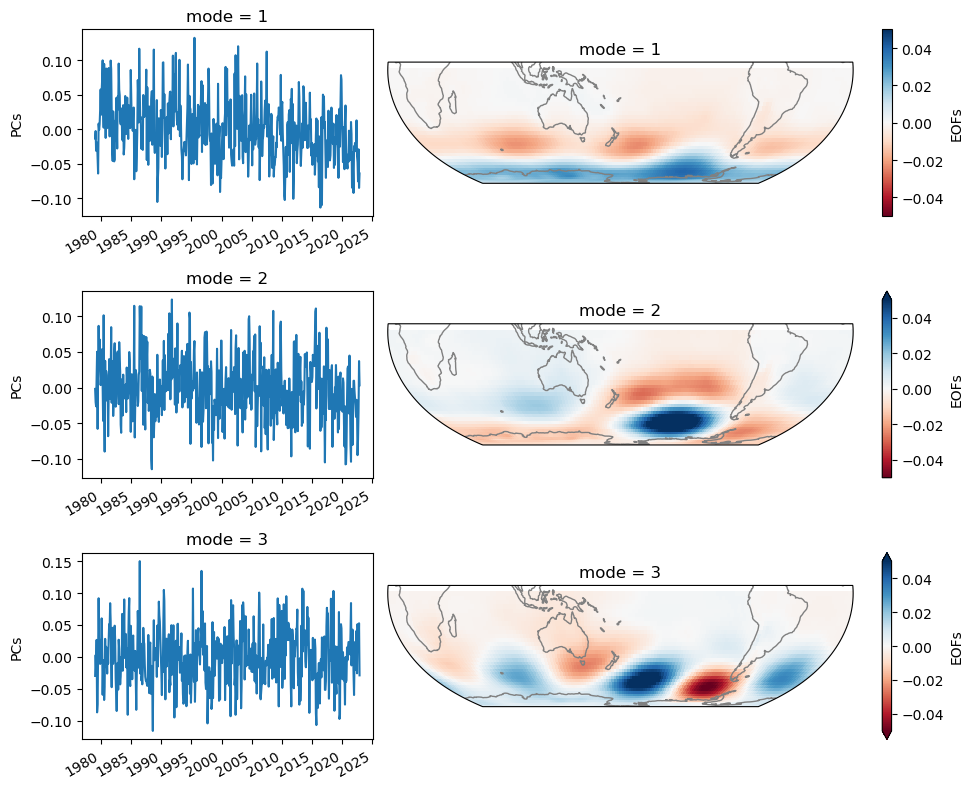

In [67]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'vmin' : -.05, 'vmax': .05, 'transform': PlateCarree()
}

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[1, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    pcs.sel(mode=i+1).plot(ax=a0)
    a1.coastlines(color='.5')
    eofs.sel(mode=i+1).plot(ax=a1, **kwargs)

    a0.set_xlabel('')

plt.tight_layout()
plt.savefig('eof-smode.jpg')